## binary classification example

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
#from binary_classifier_NN import BinaryClassifierNN
from classifier_NN import ClassifierNN
import PIL.Image as Image


In [2]:
import cupy as np

In [3]:
print(np.cuda.runtime.getDeviceCount())

1


## car-bike dataset

In [ ]:
COLAB = True
if COLAB:
  # Let's make sure the kaggle.json file is present.
  !ls -lha kaggle.json
  # Next, install the Kaggle API client.
  !pip install -q kaggle
  # The Kaggle API client expects this file to be in ~/.kaggle,
  # so move it there.
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/

  # This permissions change avoids a warning on Kaggle tool startup.
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download -d utkarshsaxenadn/car-vs-bike-classification-dataset
  !unzip car-vs-bike-classification-dataset
  !pip install split-folders


In [6]:
import splitfolders
splitfolders.ratio('Car-Bike-Dataset', output="car_bike", seed=1337, ratio=(.7, .2, .1)) # default values')

Copying files: 4000 files [00:00, 4442.66 files/s]


### data preprocessing

In [7]:
headings = os.listdir('car_bike')
print(headings)

['test', 'train', 'val']


In [8]:
# initialize empty pandas dataframe
dataset = dict()
for heading in headings:
    dataset[heading] = {}
    for class_name in os.listdir('car_bike/' + heading):
        dataset[heading][class_name] = len(os.listdir('car_bike/' + heading + '/' + class_name))

In [9]:
pd.DataFrame(dataset)

,test,train,val
Car,200,1400,400
Bike,200,1400,400


In [10]:
l = sorted(os.listdir('car_bike/train'),reverse=True)
l

['Car', 'Bike']

In [11]:
X_train = []
Y_train = []

for class_no,class_name in enumerate(sorted(os.listdir('car_bike/train'))):
    print(class_no,class_name)
    for file_name in os.listdir('car_bike/train/' + class_name):
        image = Image.open('car_bike/train/' + class_name + '/' + file_name)
        image = image.resize((64, 64))
        image = np.array(image)
        if image.shape == (64, 64, 3):
            X_train.append(image)
            Y_train.append(class_no)

X_train = np.array(X_train)
Y_train = np.array(Y_train)


0 Bike
1 Car


In [12]:
X_val = []
Y_val = []

for class_no ,class_name in enumerate(sorted(os.listdir('car_bike/val'))):
    print(class_no, class_name)
    for file_name in os.listdir('car_bike/val/' + class_name):
        image = Image.open('car_bike/val/' + class_name + '/' + file_name)
        image = image.resize((64, 64))
        image = np.array(image)
        if image.shape == (64, 64, 3):
            X_val.append(image)
            Y_val.append(class_no)

X_val = np.array(X_val)
Y_val = np.array(Y_val)

0 Bike
1 Car


In [13]:
X_test = []
Y_test = []

for class_no,class_name in enumerate(sorted(os.listdir('car_bike/test'))):
    print(class_no,class_name)
    for file_name in os.listdir('car_bike/test/' + class_name):
        image = Image.open('car_bike/test/' + class_name + '/' + file_name)
        image = image.resize((64, 64))
        image = np.array(image)
        if image.shape == (64, 64, 3):
            X_test.append(image)
            Y_test.append(class_no)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

0 Bike
1 Car


In [14]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((2784, 64, 64, 3),
 (2784,),
 (796, 64, 64, 3),
 (796,),
 (397, 64, 64, 3),
 (397,))

In [15]:
X_train.device, Y_train.device, X_val.device, Y_val.device, X_test.device, Y_test.device

(<CUDA Device 0>,
 <CUDA Device 0>,
 <CUDA Device 0>,
 <CUDA Device 0>,
 <CUDA Device 0>,
 <CUDA Device 0>)

In [16]:
# normalize
X_train = X_train / 255
X_val = X_val / 255
X_test_normalized = X_test / 255

# flatten
X_train = X_train.reshape(X_train.shape[0], -1).T # this will be of shape (n, m)
X_val = X_val.reshape(X_val.shape[0], -1).T
X_test_normalized = X_test.reshape(X_test_normalized.shape[0], -1).T

In [17]:
Y_train = Y_train.reshape(1, Y_train.shape[0])
Y_val = Y_val.reshape(1, Y_val.shape[0])
Y_test = Y_test.reshape(1, Y_test.shape[0])

In [18]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((12288, 2784), (1, 2784), (12288, 796), (1, 796), (397, 64, 64, 3), (1, 397))

In [19]:
# shuffle the training data
np.random.seed(2)
permutation = np.random.permutation(X_train.shape[1])
X_train = X_train[:, permutation]
Y_train = Y_train[:, permutation]

# shuffle the validation data
np.random.seed(2)
permutation = np.random.permutation(X_val.shape[1])
X_val = X_val[:, permutation]
Y_val = Y_val[:, permutation]

In [35]:
# initialize model
model = ClassifierNN(layer_dims=[X_train.shape[0], 25, 15, 5, 1], activations=['relu', 'relu', 'relu', 'sigmoid'])

In [41]:
params, costs = model.train(X_train, Y_train, learning_rate=0.001, num_epochs=1000, print_cost=True, optimizer="adam")

Cost after iteration 0: 1.0687348675340562
Cost after iteration 100: 0.08160044463161961
Cost after iteration 200: 0.0006839758595730211
Cost after iteration 300: 3.6935885328322566e-05
Cost after iteration 400: 2.760418912793351e-06
Cost after iteration 500: 1.9158128086782963e-07
Cost after iteration 600: 1.6168430983347698e-08
Cost after iteration 700: 1.4815793220328326e-09
Cost after iteration 800: 1.7473793564422306e-10
Cost after iteration 900: 0.6950595993825006


In [ ]:
costs

In [23]:
import matplotlib.pyplot as plt

In [42]:
costs = [np.asnumpy(cost) for cost in costs]

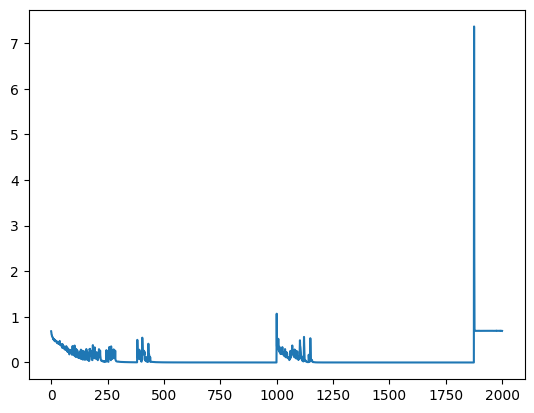

In [43]:
plt.plot(costs)

In [44]:
Y_prid_test = model.predict(X_test_normalized)

In [45]:
model.accuracy(X_test_normalized,Y_test)

array(0.49874055)

Text(0.5, 1.0, 'The prediction is : Bike')

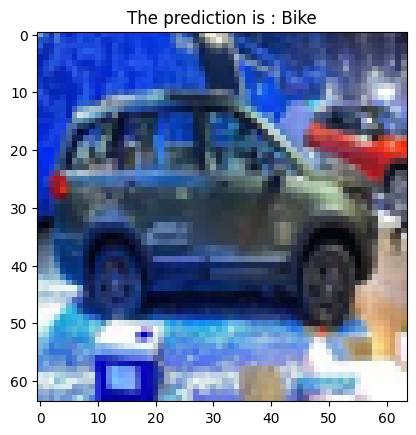

In [28]:
test_num = 344
plt.imshow(np.asnumpy(X_test[test_num,:].reshape(64,64,3)))
prediction = 'Car' if Y_prid_test[0,test_num] == 1 else 'Bike'
plt.title(f"The prediction is : {prediction}")

In [29]:
test_image = Image.open('download.jfif')
test_image = test_image.resize((64, 64))
test_image = np.array(test_image)
plt.imshow(np.asnumpy(test_image))
# test_image = np.expand_dims(test_image,axis=0)
test_image = test_image / 255
test_image = test_image.reshape(-1,1)
prediction = model.predict(test_image)
prediction = 'Car' if prediction == 1 else 'Bike'
plt.title(f"The prediction is : {prediction}")

FileNotFoundError: ignored

## multi-class classification 

In [131]:
import pandas as pd
import numpy as np

In [132]:
iris = pd.read_csv('iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [133]:
iris['species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

### visualizations 

c:\Users\TOSHIBA\anaconda3\envs\dl_tf\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


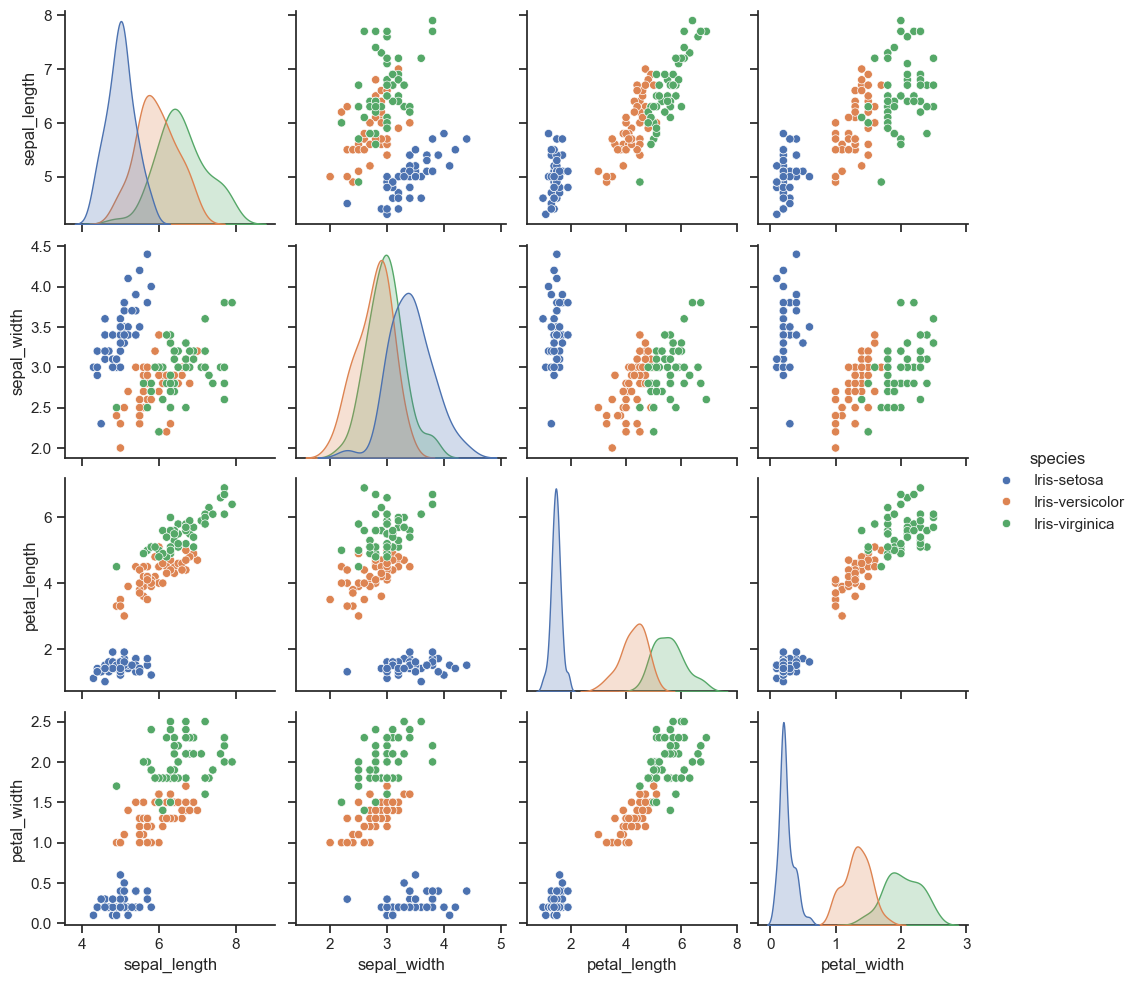

In [5]:
# plot each pair of features against each other in a scatter plot and color by species
import seaborn as sns
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(iris, hue="species")


### preprocess the dataset

In [134]:
# extract the features and labels
X = iris.iloc[:, 0:4].values
Y = iris.iloc[:, 4].values
X.shape, Y.shape

((150, 4), (150,))

In [135]:
# normalize the data using z-score normalization
X = (X - X.mean(axis=0)) / X.std(axis=0)
X = X.T
X.shape # will be of shape (n, m)

(4, 150)

In [136]:
Y = [0 if y == 'Iris-setosa' else 1 if y == 'Iris-versicolor' else 2 for y in Y]
Y = np.array(Y).reshape(1, len(Y))
Y.shape

(1, 150)

In [137]:
# shuffle the data
np.random.seed(2)
permutation = np.random.permutation(X.shape[1]) # this will generate a random permutation of numbers from 0 to m-1
X = X[:, permutation]
Y = Y[:, permutation]

In [138]:
Y = np.eye(3)[Y.reshape(-1)].T # one-hot encode the labels
Y.shape

(3, 150)

In [139]:
X.shape, Y.shape

((4, 150), (3, 150))

In [140]:
# split the data into train, and test sets
X_train = X[:, 0:100]
Y_train = Y[:, 0:100]
X_test = X[:, 100:]
Y_test = Y[:, 100:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((4, 100), (3, 100), (4, 50), (3, 50))

### train the model 

In [222]:
import importlib
import classifier_NN 
importlib.reload(classifier_NN)
model = classifier_NN.ClassifierNN(layer_dims=[X_train.shape[0], 25, 15, 10, 3], activations=['relu', 'relu', 'relu', 'softmax'])

In [239]:
params, costs = model.train(X=X_train, Y=Y_train, learning_rate=0.000001, num_epochs=1000, print_cost=True, optimizer="gd", loss="CategoricalCrossEntropy")

Cost after iteration 0: 0.306288176729545


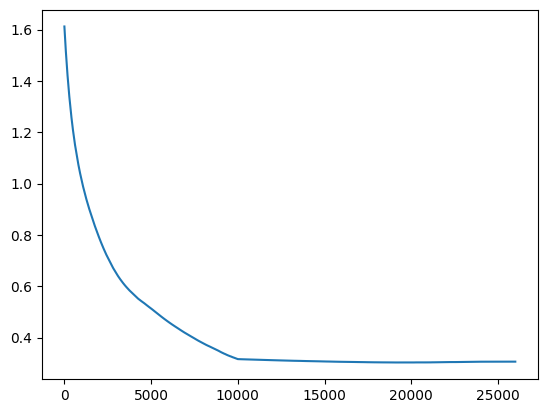

In [242]:
import matplotlib.pyplot as plt
plt.plot(costs)

In [241]:
model.accuracy(X_test, Y_test)

0.9333333333333333